In [1]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import star
from dataclasses import dataclass
import tables
from phd.thunderstorm import atmosphere
from itertools import cycle
from phd.thunderstorm.dwyer_feedback import get_dwyer_line, FeedBack, get_feedback_dwyer2003, load_reversed_data, \
    load_reversed_energy
from phd.utils.path_tools import get_attrs_values

In [2]:
mpl.rcParams.update(
    {'font.family': 'sans-serif',
     'font.size': 16,
     'axes.labelsize': 16,
     'xtick.labelsize': 16,
     'ytick.labelsize': 16,
     'legend.fontsize': 16})

image_path = '/home/zelenyy/npm/scientific-papers/Russian-Phd-LaTeX-Dissertation/Dissertation/images/'

# Потери в атмосфере

In [3]:
def get_stopping_power(min_energy=0.01, max_energy=150):
    material = star.electron.PredefinedMaterials.AIR_DRY_NEAR_SEA_LEVEL
    data = star.electron.calculate_estar_table(material)
    energy = data["energy"]
    indx = (energy < max_energy) * (energy>min_energy)
    energy = energy[indx]
    stopPower = data["stopping_power_total"][indx]
    return energy, stopPower

In [4]:
energy, stopPower = get_stopping_power(0.01, 150)
density = atmosphere.ISACalculator.density(0.0) # kg/m3
print("Предельное поле в нормальных условиях:", stopPower.min()*density)

Предельное поле в нормальных условиях: 2.0470466951619404


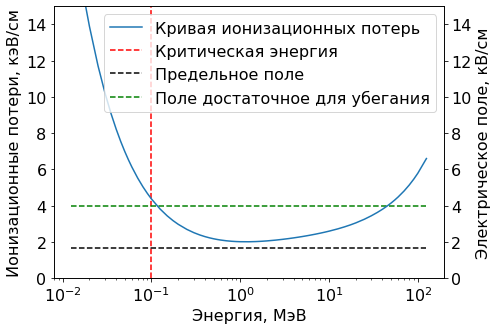

In [8]:
energy, stopPower = get_stopping_power(0.01, 150)

fig, ax1 = plt.subplots(figsize = (7, 5))
plt.plot(energy,stopPower*1.2e-3*1e3, label="Кривая ионизационных потерь")
ax1.set_ylim(0,15)
n = len(energy)
plt.vlines(0.1, 0 ,15, "r", linestyles="--", label="Критическая энергия")
plt.hlines(stopPower.min(), energy.min(), energy.max(),"k", linestyles="--", label="Предельное поле")
plt.hlines(4, energy.min(), energy.max(), "g", linestyles="--",label = "Поле достаточное для убегания")
# plt.plot(energy, np.ones(n)*4)
plt.xlabel(u'Энергия, МэВ')
plt.ylabel(r'Ионизационные потери, кэВ/см')
plt.xscale('log')
plt.legend(loc=0)
# plt.title(u'Energy loss');

ax2 = ax1.twinx()
ax2.set_ylim(0,15)
# ax2.hlines(1.5, energy.min(), energy.max(),"r", linestyles="--")
# ax2.hlines(4, energy.min(), energy.max(), "g", linestyles="--")
# ax2.plot(energy, np.ones(n)*1.5, 'r')
# ax2.plot(energy, np.ones(n)*4, 'g')
plt.ylabel(r'Электрическое поле, кВ/см');
# plt.legend()
# plt.tight_layout();
plt.savefig(os.path.join(image_path, "thunderstorm", '01_Gurevich.pdf'), transparent=True, format='pdf');

# Критическая энергия

## Оценка по потерям

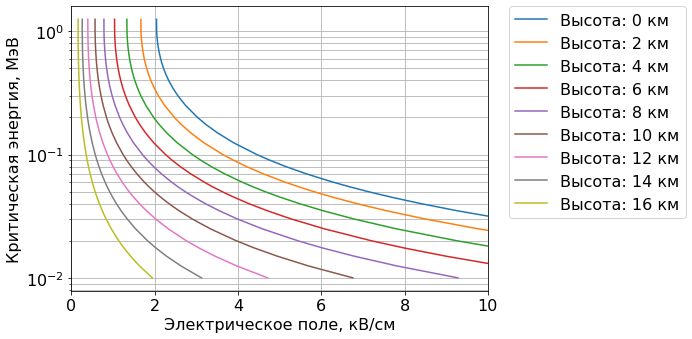

In [15]:
energy, stopPower = get_stopping_power(0.001, 1.5)

plt.figure(figsize=(10,5))
for h in np.arange(0, 17000, 2000):
    density = atmosphere.ISACalculator.density(h) # kg/m3
    y = stopPower*density # кэВ/см == кВ/см
    plt.plot(y, energy, label = "Высота: {} км".format(int(h/1000)))
plt.yscale("log")
plt.grid(which = "both")
plt.xlabel(r'Электрическое поле, кВ/см');
plt.ylabel(r'Критическая энергия, МэВ')
plt.xlim(0,10)
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);
# leg.set_in_layout(False)
plt.tight_layout();
plt.savefig(os.path.join(image_path,"thunderstorm", '02_CriticalEnergy.pdf'), transparent=True, format='pdf');


In [7]:
from tabulate import tabulate

energy, stopPower = get_stopping_power(0.001, 1.5)

critical_energy = [energy]
labels = ['Критическая энергия, МэВ']
for h in np.arange(0, 17000, 2000):
    density = atmosphere.ISACalculator.density(h) # kg/m3
    y = stopPower*density # кэВ/см == кВ/см
    critical_energy.append(y)
    labels.append("Высота: {} км".format(int(h/1000)))
    # plt.plot(y, energy, label = "Высота: {} км".format(int(h/1000)))

# plt.xlabel(r'Электрическое поле, кВ/см');
# plt.ylabel(r'Критическая энергия, МэВ')
text = tabulate(zip(*critical_energy), headers=labels)
print(text)

  Критическая энергия, МэВ    Высота: 0 км    Высота: 2 км    Высота: 4 км    Высота: 6 км    Высота: 8 км    Высота: 10 км    Высота: 12 км    Высота: 14 км    Высота: 16 км
--------------------------  --------------  --------------  --------------  --------------  --------------  ---------------  ---------------  ---------------  ---------------
                    0.01          24.2            19.7706         15.7943         12.2936         9.28172          6.76027          4.71739          3.12651          1.94613
                    0.0125        20.3748         16.6456         13.2978         10.3504         7.81462          5.69172          3.97175          2.63232          1.63852
                    0.015         17.6993         14.4597         11.5515          8.99123        6.78842          4.9443           3.45019          2.28665          1.42335
                    0.0175        15.7146         12.8383         10.2562          7.98301        6.02721          4.38988      

In [5]:

for h in np.arange(0, 17000, 1000):
    pressure = atmosphere.ISACalculator.pressure(h)
    print(h, pressure/ atmosphere.P0)

0 1.0
1000 0.8857731161145405
2000 0.7801105265974527
3000 0.6828420790258434
4000 0.5937673833604603
5000 0.5126554239931883
6000 0.43924450652255087
7000 0.37324259586735037
8000 0.31432810388620114
9000 0.2621511843425739
10000 0.21633559018396725
11000 0.17648114193141085
12000 0.14216684566005902
13000 0.11295468370765527
14000 0.08839408001442986
15000 0.06802701414806495
16000 0.051393723165488535


## Оценка по моделированию

In [8]:
# path = "/mnt/storage2/phd/data/thunderstorm/critical_energy/critical_energy.npy"
path = "/home/zelenyy/storage1/data/phd/data/thunderstorm/critical_energy/critical_energy_up.npy"

In [9]:
def get_critical_energy(path):
    data = np.load(path)
    result = []
    dtype=np.dtype([("height", 'd'), ("field", "d"), ("critical_energy", "d"),
                    ("rate", "d"), ("chi2", "d"), ("coverage", np.bool_)])
    hf = np.unique(data[["height", "field"]], axis=0)
    for item in hf:
        height, field = item
        indx = np.logical_and(data["height"] == height, data["field"] == field)
        x = data["energy"][indx]
        y =  data["k"][indx]
        chi2 = data["chi2"][indx]
        indx_x = np.argsort(x)
        x = x[indx_x]
        y = y[indx_x]
        chi2 = chi2[indx_x]
        indx = y > 0.001
        if np.all(np.logical_not(indx)):
            ce = x[-1]
            chi2_x = chi2[-1]
            k = y[-1]
            coverage = False
        elif np.all(indx):
            ce = x[0]
            chi2_x = chi2[0]
            k = y[0]
            coverage = False
        else:
            indx = indx.argmax()
            ce = x[indx]
            chi2_x = chi2[indx]
            k = y[indx]
            coverage = True
        result.append((height, field, ce, k, chi2_x, coverage))
    return np.array(result, dtype=dtype)


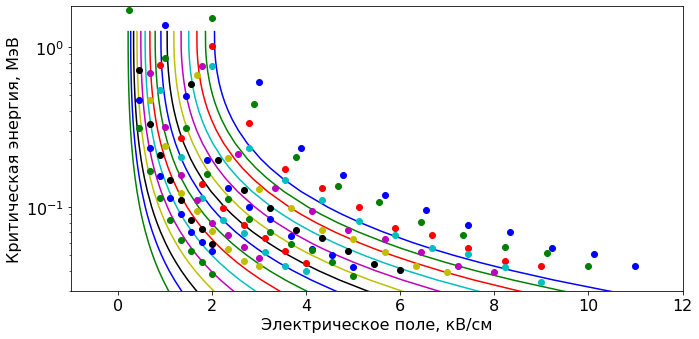

In [13]:
result = get_critical_energy(path)
heights = np.unique(result["height"])
field_units = 1e+4
energy, stopPower = get_stopping_power(0.001, 1.5)
colors = cycle(["b", "g", "r", "c", "m", "y", "k"])
plt.figure(figsize=(10,5))
for i, height in enumerate(heights):
    indx = result["height"] == height
    x = result["field"][indx]*field_units
    y = result["critical_energy"][indx]
    density = atmosphere.ISACalculator.density(height) # kg/m3
    spd = stopPower*density # кэВ/см == кВ/см
    color = next(colors)
    plt.plot(x,y, "o", color=color)
    plt.plot(spd, energy,color=color,  label = "Высота: {} км".format(int(height/1000)))
plt.xlim(-1,12)
plt.ylim(0.03)
plt.yscale("log")
plt.xlabel(r'Электрическое поле, кВ/см')
plt.ylabel(r'Критическая энергия, МэВ')
# plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_path, "thunderstorm", "03_CriticalEnergyWithSim.pdf"), transparent=True, format='pdf')


# Убегающие электроны

# Спутник

In [20]:
mpl.rcParams.update(
    {'font.family': 'sans-serif',
     'font.size': 14,
     'axes.labelsize': 14,
     'xtick.labelsize': 14,
     'ytick.labelsize': 14,
     'legend.fontsize': 14})

In [21]:
sat_image_path = '/home/zelenyy/npm/another/scientific-papers/Russian-Phd-LaTeX-Dissertation/Dissertation/images/satellite/'

In [22]:
from phd.satellite.scr import get_parameters, scr_proton_spectrum, load_electron_spectrum, scr_electron_spectrum
scr_parameters = get_parameters()

ImportError: cannot import name 'load_electron_spectrum' from 'phd.satellite.scr' (/home/zelenyy/npm/phd/phd-code/python/phd/satellite/scr.py)

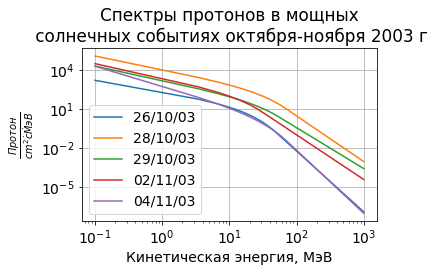

In [23]:

energy = np.linspace(0.1, 1000, num=300)
for parameters in scr_parameters:
    data = scr_proton_spectrum(energy, parameters)
    plt.plot(energy, data/parameters.dt, label=parameters.event)
plt.title("Спектры протонов в мощных\n солнечных событиях октября-ноября 2003 г")
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.xlabel("Кинетическая энергия, МэВ")
plt.ylabel(r"$\frac{Протон}{cm^2\dot c\dot МэВ}$")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(sat_image_path, "proton_spectrum.pdf"), format="pdf", transparent=True)

In [24]:
energy = np.linspace(0.01, 100, num=300)
path = "/mnt/storage2/phd/data/satellite/Theory/electron_spectrum_jgr_110_2005.dat"
electon_parameters  = load_electron_spectrum(path)
for parameters in electon_parameters:
    data = scr_electron_spectrum(energy, parameters)
    plt.plot(energy, data/parameters.dt, label=parameters.event)
plt.title("Спектры солнечных энергичных электронов 2005 г")
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.xlabel("Кинетическая энергия, МэВ")
plt.ylabel(r"$\frac{Электрон}{cm^2\dot c\dot МэВ}$")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(sat_image_path, "electron_spectrum.pdf"), format="pdf", transparent=True)

NameError: name 'load_electron_spectrum' is not defined

# Минимальное поле для убегания

In [5]:
path = "/mnt/storage2/phd/data/thunderstorm/minimal_field/minimal_field.npy"
data = np.load(path)

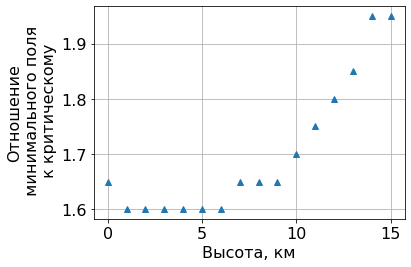

In [10]:
plt.plot( data["height"]/1000, data["field"]/(1e-4*data["baseline"]), "^")
plt.xlabel("Высота, км")
plt.ylabel("Отношение\n минимального поля\n к критическому");
plt.grid()
plt.tight_layout()

# Нейтроны в грозе

In [10]:
neutron_path = os.path.join(image_path, "thunderstorm/neutron")


In [11]:
def get_data(path):
    with tables.open_file(path) as h5file:
        result = []
        n = 0
        for group in h5file.root:
            table = h5file.get_node(group, "stacking_simple")
            number = table.attrs["values_macros_number"]
            n += number
            data = table.read()
            result.append(data)
        return np.hstack(result), 1.0/n

def plot_z_hist(data, save_path, name="air", weight = 1):
    indx = data["z"] < 800000
    plt.hist(data["z"][indx]/1000, weights=weight*np.ones(np.sum(indx)))
    plt.yscale("log")
    plt.xlabel("Высота, км")
    plt.ylabel("Число нейтронов")
    plt.tight_layout()
    plt.savefig(os.path.join(save_path,name + ".pdf"), fmt="pdf", transparent=True)

In [7]:
path = "/mnt/storage2/phd/data/thunderstorm/neutron/spacecraft_opt4_h15km.hdf5"
data_opt4, weight = get_data(path)

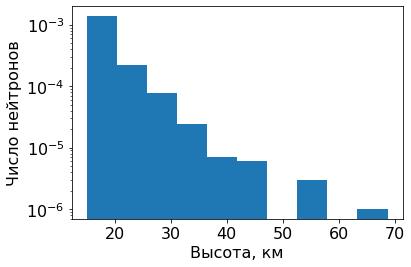

In [12]:
plot_z_hist(data_opt4,neutron_path, name="air_z_100MeV", weight=weight)

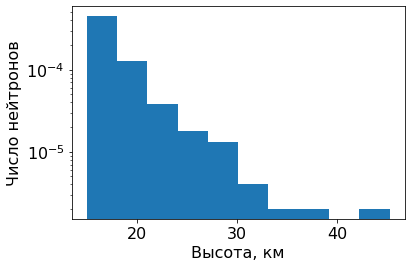

In [13]:
path = "/mnt/storage2/phd/data/thunderstorm/neutron/spacecraft_opt4_h15km_e15MeV.hdf5"
data_opt4_15, weight = get_data(path)

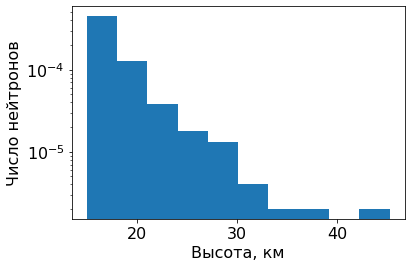

In [16]:
plot_z_hist(data_opt4_15,neutron_path, weight=weight, name="air_z_15MeV")

In [15]:
(data_opt4_15["z"] < 80000).sum() * weight*1000


0.6589999999999999

# Разворот при нормальных условиях

In [4]:
rdfm_path = os.path.join(image_path, "thunderstorm/rdfm")

In [5]:
path = "/mnt/storage2/phd/data/thunderstorm/reversed_1/grid_v2.hdf5"
fields = get_attrs_values(path, "values_gdml_fieldValueZ")
# heigths = get_attrs_values(path, "values_gdml_height")

In [7]:
def plot(path, save_path, field=8e-4):
    theta, energy, probability = load_reversed_data(path, field)
    xi = np.sort(np.unique(theta))
    yi = np.sort(np.unique(energy))
    X,Y = np.meshgrid(xi,yi)
    Z = np.zeros(X.shape)
    for t, e, p in zip(theta, energy, probability):
        indx = np.where(xi == t)[0][0]
        indy = np.where(yi == e)[0][0]
        Z[indy, indx] = p
    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=14);
    ax.set_title("Электрическое поле {:.1f} кВ/см".format(field*1e4))
    ax.set_xlabel(r"$\theta$, градусы")
    ax.set_ylabel(r"Энергия, МэВ")
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "reverse_{:.1f}.pdf".format(field*1e4).replace(".", "_", 1)), fmt="pdf", transparent=True)

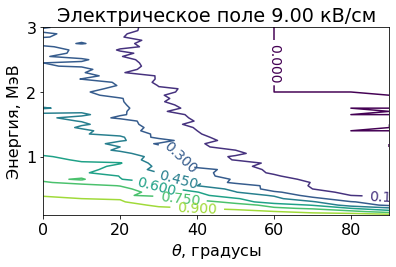

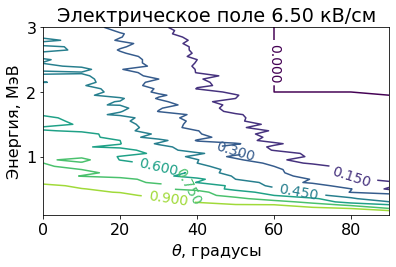

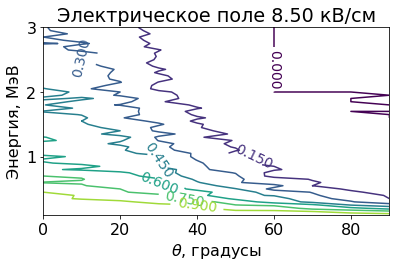

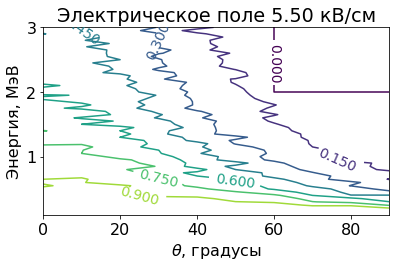

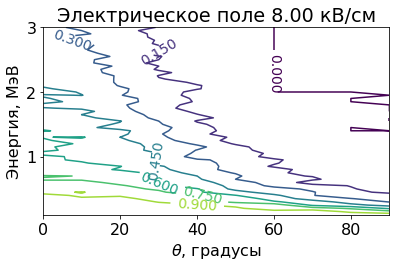

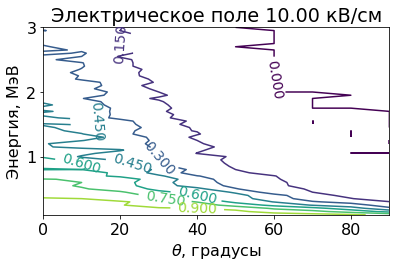

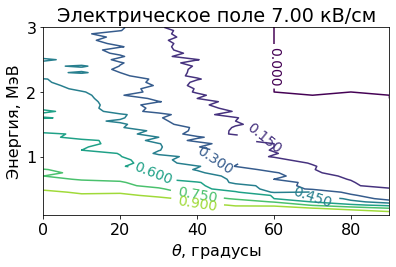

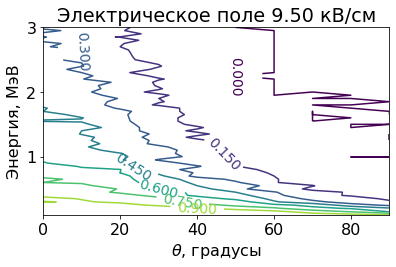

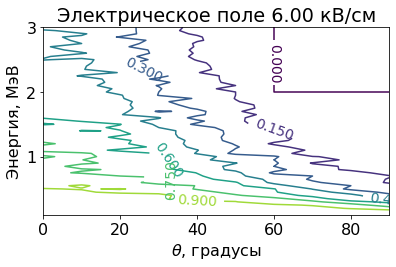

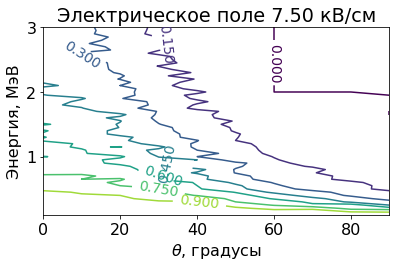

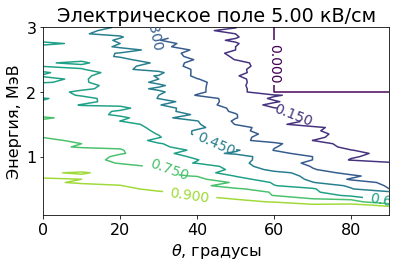

In [8]:
for field in fields:
    plot(path, rdfm_path, field)

In [9]:
def plot_energy(path,save_path, field=8e-4, heigth=0):
    theta, energy, result = load_reversed_energy(path, field, heigth)
    # min_energy = list(map(my_min, result))
    # max_energy = list(map(my_max, result))
    mean_energy = list(map(lambda x: x['energy'].mean(), result))
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,3), np.linspace(0,3))
    ax.scatter(energy, mean_energy)
    # plt.scatter(energy, min_energy)
    # plt.scatter(energy, max_energy)
    ax.set_xlabel("Начальная энергия, МэВ")
    ax.set_ylabel("Энергия после\n разворота, МэВ")
    ax.set_title("Электрическое поле {:.1f} кВ/см".format(field*1e4))
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "reverse_energy_{:.1f}.pdf".format(field*1e4).replace(".", "_", 1)), fmt="pdf", transparent=True)

/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zelenyy/minic

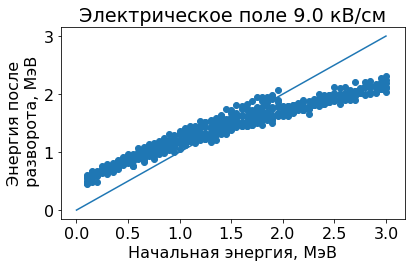

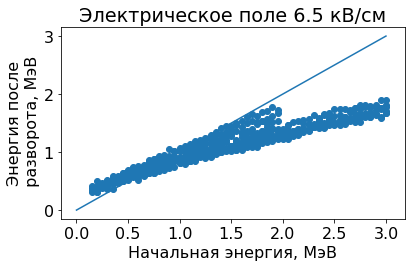

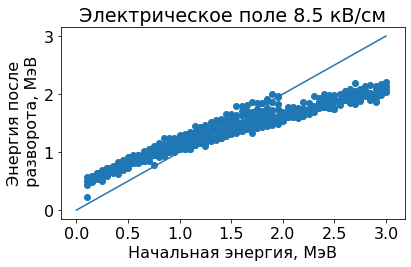

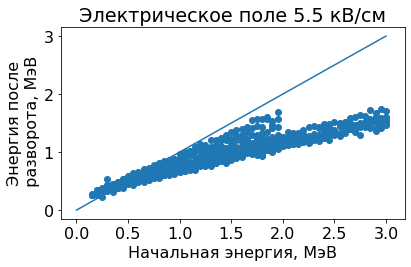

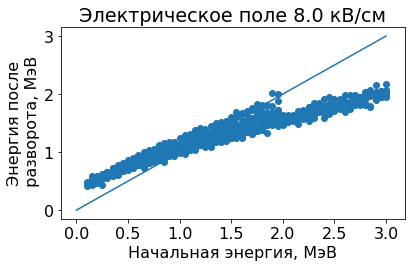

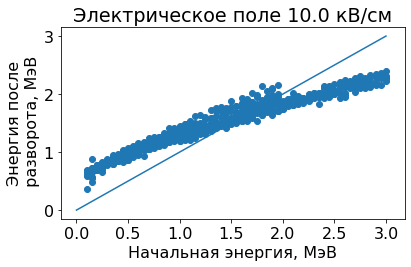

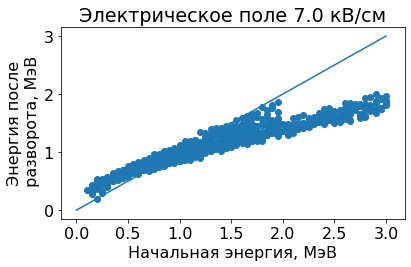

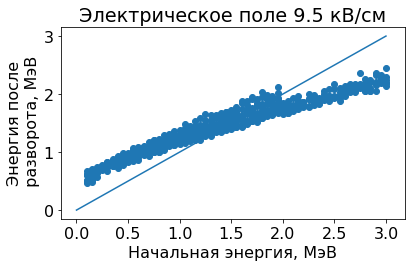

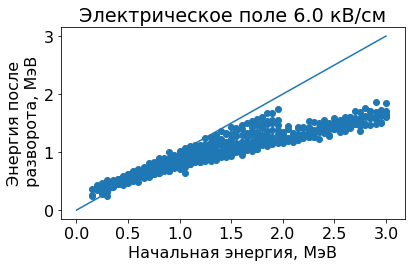

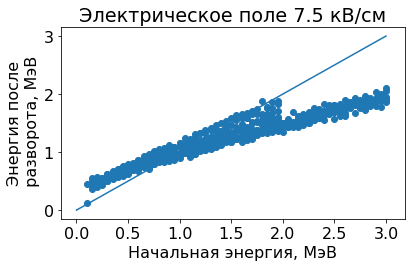

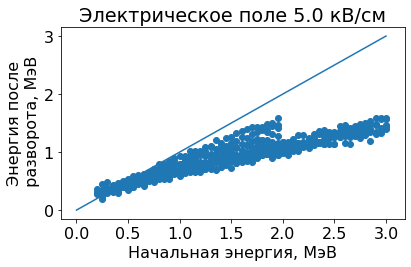

In [10]:
for field in fields:
    plot_energy(path, rdfm_path, field)

# Модели с обратной связью

In [7]:
import warnings
warnings.simplefilter("ignore")
rdfm_path = os.path.join(image_path, "thunderstorm/rdfm")

In [5]:
summary_result = get_feedback_dwyer2003()

field 0.0005
[]
field 0.0005
['/sim0005']
field 0.0005
[]
field 0.0005
[]
field 0.0005
[]
field 0.0005
[]
field 0.00055
['/sim0001']
field 0.00055
['/sim0004']
field 0.00055
[]
field 0.00055
[]
field 0.00055
[]
field 0.00055
[]
field 0.0006000000000000001
[]
field 0.0006000000000000001
[]
field 0.0006000000000000001
[]
field 0.0006000000000000001
[]
field 0.0006000000000000001
[]
field 0.0006000000000000001
[]
field 0.0006500000000000001
[]
field 0.0006500000000000001
[]
field 0.0006500000000000001
[]
field 0.0006500000000000001
[]
field 0.0006500000000000001
[]
field 0.0006500000000000001
[]
field 0.0007
[]
field 0.0007
['/sim0002']
field 0.0007
['/sim0002']
field 0.0007
['/sim0002', '/sim0004', '/sim0006', '/sim0008']
field 0.0007
['/sim0002', '/sim0005', '/sim0008', '/sim0011']
field 0.0007
['/sim0002']
field 0.00075
[]
field 0.00075
[]
field 0.00075
[]
field 0.00075
[]
field 0.00075
[]
field 0.00075
[]
field 0.0008
[]
field 0.0008
[]
field 0.0008
[]
field 0.0008
[]
field 0.0008
[]


In [12]:
sum_fed_path = "/mnt/storage2/phd/data/thunderstorm/sum_feed_back_phd.obj"
with open(sum_fed_path, "rb") as fin:
    summary_result_file = pickle.load(fin)

In [7]:
summary_result

[FeedBack(height=0, field=0.0005, cell=500, gamma=51.04, positron=137.86999999999998, gamma_err=7.1442284397967, positron_err=11.741805653305626, number_of_seed=1),
 FeedBack(height=0, field=0.0004, cell=1000, gamma=0.0, positron=0.0, gamma_err=0.0, positron_err=0.0, number_of_seed=1),
 FeedBack(height=0, field=0.00045, cell=700, gamma=110.725, positron=335.69500000000005, gamma_err=10.52259473704086, positron_err=18.321981333906006, number_of_seed=1),
 FeedBack(height=0, field=0.0006, cell=300, gamma=30.30859375, positron=57.846406250000015, gamma_err=0.9732130058150168, positron_err=1.3445074173512397, number_of_seed=32)]

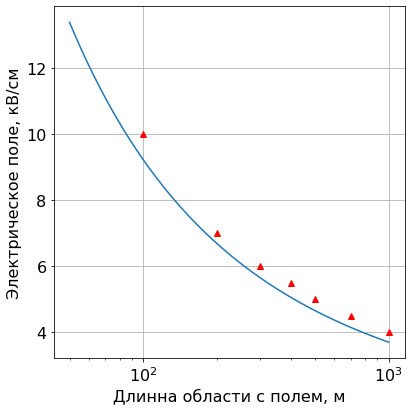

In [9]:
dwyer_line = get_dwyer_line()
x = np.arange(50, 1001, 1)
plt.figure(figsize=(6,6))
plt.plot(x, dwyer_line(x)/100)
plt.xscale("log")
plt.ylabel("Электрическое поле, кВ/см")
plt.xlabel("Длинна области с полем, м")
plt.grid(True)
for item in summary_result:
    plt.plot(item.cell, item.field*1e4, "r^")
    text = "({:.0f} : {:.0f})".format(item.cell, item.field*1e4)
plt.tight_layout()
plt.savefig(os.path.join(rdfm_path, "dwyer_2003.pdf"),  fmt="pdf", transparent=True)